Here we estimate the following conditional expectation function:
$$
\mathbb{E}[valuation_i|ispolice_i]=\alpha+\beta_1 ispolice_i,
$$
using the entire sample where the number of bids received is equal to 6.

In [1]:
import pandas as pd
import numpy as np
from scipy import optimize, integrate
from main import estimate_mean, get_loss_function, estimate_median, get_order_statistic_pdfs, get_cdf, FastMean, cdf

data = pd.read_csv("../../data/demeaned.csv")
df = data.groupby(["id", "ispolice", "sellerfeedbackscore", "bidcount", "apple", "amazon"])["bids"].apply(lambda x: x.values).reset_index()

In [2]:
include = df[df.bidcount == 6]

bids = list(include.bids)
covariates = [[cov] for cov in list(include.ispolice)]

In [3]:
expected_upper, expected_lower, u_cdfs, l_cdfs = estimate_mean(bids, covariates, (0,9))

calculating values for covariate: [0] (1/2)
total time elapsed: 0.0001611580000000501s


/Users/liumukun/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1695: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


calculating values for covariate: [1] (2/2)
total time elapsed: 113.33065971799999s


In [4]:
def loss_function(c):
    a, b = c
    cef = lambda cov: a+b*cov[0]
    return get_loss_function(covariates, expected_upper, expected_lower, cef)

b_hat = optimize.brute(loss_function, ranges=[(0,2), (-1,1)])
# interval_lower = optimize.newton(lambda a_l, b_l: loss_function(a_l, b_l)-loss_function(b_hat)-10, b_hat-0.1)
# interval_upper = optimize.newton(lambda b_l, b_u: loss_function(b_l, b_u)-loss_function(b_hat)-10, b_hat+0.1)

In [5]:
b_hat

array([ 1.73156917, -0.11976303])

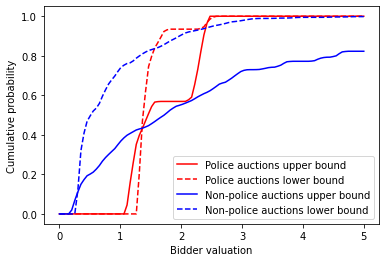

In [6]:
from scipy import interpolate
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

vals = np.linspace(0,5,num=100)

int_cdf_u_police = interpolate.interp1d(np.linspace(0,9,num=100), u_cdfs["[1]"], bounds_error=False, fill_value=(0,1))
plt.plot(vals, [int_cdf_u_police(v) for v in vals], label="Police auctions upper bound", color="red")

int_cdf_l_police = interpolate.interp1d(np.linspace(0,9,num=100), l_cdfs["[1]"], bounds_error=False, fill_value=(0,1))
plt.plot(vals, [int_cdf_l_police(v) for v in vals], label="Police auctions lower bound", color="red", linestyle="--")

int_cdf_u_not = interpolate.interp1d(np.linspace(0,9,num=100), u_cdfs["[0]"], bounds_error=False, fill_value=(0,1))
plt.plot(vals, [int_cdf_u_not(v) for v in vals], label="Non-police auctions upper bound", color="blue")

int_cdf_l_not = interpolate.interp1d(np.linspace(0,9,num=100), l_cdfs["[0]"], bounds_error=False, fill_value=(0,1))
plt.plot(vals, [int_cdf_l_not(v) for v in vals], label="Non-police auctions lower bound", color="blue", linestyle="--")

plt.ylabel("Cumulative probability")
plt.xlabel("Bidder valuation")
plt.legend()

In [7]:
pdfs, pdfs_delta = get_order_statistic_pdfs(bids, covariates)
x_val = [0]
interpolation_range=(0,9)

In [8]:
x0, x1 = interpolation_range

conditional_pdfs = {key: [pdf(x_val) for pdf in value] for key, value in pdfs.items()}
conditional_pdfs_delta = {key: pdf(x_val) for key, pdf in pdfs_delta.items()}

parent_cdf_estimates_upper = []
parent_cdf_estimates_lower = []

conditional_cdfs = []

for key in conditional_pdfs:

    N_BIDS = int(key)

    # weight = integrate.quad(conditional_pdfs[key][0], a=0, b=np.inf)[0]
    weight = 1

    conditional_pdf_N = [lambda y, pdf=pdf: pdf(y)/weight for pdf in conditional_pdfs[key]]


    for i in range(N_BIDS):

        conditional_pdf_i_N = conditional_pdf_N[i]
        weight = integrate.quad(conditional_pdf_i_N, a=0, b=np.inf)[0]
        conditional_cdf_i_N = lambda y, weight=weight, conditional_pdf_i_N=conditional_pdf_i_N: integrate.quad(conditional_pdf_i_N, a=0, b=y)[0]/weight
        
        conditional_cdfs.append(conditional_cdf_i_N)
        
        parent_conditional_cdf_from_i_N = lambda x, i=i, conditional_cdf_i_N=conditional_cdf_i_N: cdf(x, conditional_cdf_i_N, i+1, N_BIDS)/cdf(x1, conditional_cdf_i_N, i+1, N_BIDS)

        parent_cdf_estimates_upper.append(parent_conditional_cdf_from_i_N)

        if i == N_BIDS - 1:

            conditional_pdf_delta_N = conditional_pdfs_delta[key]
            conditional_cdf_delta_N = lambda y, conditional_pdf_delta_N=conditional_pdf_delta_N: integrate.quad(conditional_pdf_delta_N, a=0, b=y)[0]

            parent_conditional_cdf_delta_from_N = lambda x, i=i: get_cdf(conditional_cdf_delta_N, i+1, N_BIDS)(x)/get_cdf(conditional_cdf_delta_N, i+1, N_BIDS)(x1)

            parent_cdf_estimates_lower.append(parent_conditional_cdf_delta_from_N)

<ipython-input-8-e9dc84d66d7a>:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  weight = integrate.quad(conditional_pdf_i_N, a=0, b=np.inf)[0]


In [9]:
values = np.linspace(0,5,num=50)

In [10]:
pdfs_0 = [pdf([0]) for pdf in pdfs["6"]]

<ipython-input-11-d68b9d68e58f>:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  weight = integrate.quad(pdfs_0[j], a=0, b=np.inf)[0]


called with i=4


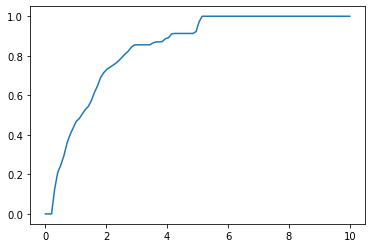

In [11]:
vals = np.linspace(0,10,num=100)

j = 3
weight = integrate.quad(pdfs_0[j], a=0, b=np.inf)[0]
conditional_pdf_i_N = lambda y: pdfs_0[j](y)/weight
conditional_cdf_i_N = lambda y, conditional_pdf_i_N=conditional_pdf_i_N: integrate.quad(conditional_pdf_i_N, a=0, b=y)[0]

parent_conditional_cdf_from_i_N_ = get_cdf(conditional_cdf_i_N, j+1, N_BIDS)
parent_conditional_cdf_from_i_N = lambda x: parent_conditional_cdf_from_i_N_(x)

plt.plot(vals, [parent_conditional_cdf_from_i_N_(v) for v in vals])


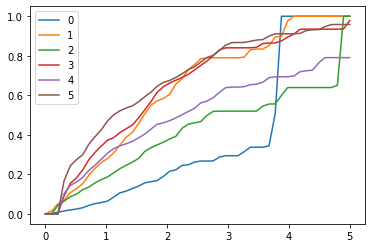

In [12]:
import matplotlib.pyplot as plt

for t, func in enumerate(conditional_cdfs):
    plt.plot(values, [cdf(v, func, t+1, 11)/cdf(10, func, t+1, 11) for v in values], label=t)
plt.legend()

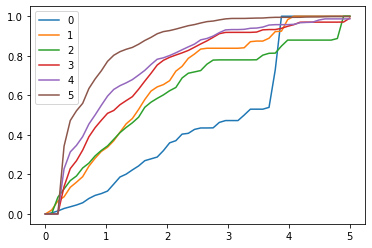

In [13]:
import matplotlib.pyplot as plt


values = np.linspace(0,5,num=50)
for t, func in enumerate(parent_cdf_estimates_upper):
    plt.plot(values, [func(v) for v in values], label=t)
plt.legend()

In [14]:
import pandas as pd

pd.DataFrame([item for sublist in bids for item in sublist]).describe()

,0
count,576.000000
mean,1.452951
std,0.881416
min,0.020939
25%,0.826186
50%,1.312553
75%,1.829724
max,6.747107
